<table width = "100%">
  <tr style="background-color:white;">
    <!-- QWorld Logo -->
    <td style="text-align:left;width:200px;"> 
        <img src="../images/QWorld.png"> </td>
    <td style="text-align:right;vertical-align:bottom;font-size:16px;"> 
        Prepared by <a href="https://gitlab.com/pjr1363" target="_blank"> Paul Joseph Robin </a></td>
    </tr> 
 </table>
 
<hr>

In [1]:
try:
    import dimod
    print("BQM Class Available!")
except ModuleNotFoundError:
    !pip3 install dwave-ocean-sdk  # For Python 3, <= 2 use pip

BQM Class Available!


---
For an introduction to the QUBO formulation of Graph Coloring, have a look at this [notebook](QUBO_Examples_GraphColoring.ipynb). I am also adding a brief recap for those already familiar with the problem.


Essentially, we would be following the vertex coloring problem. Given a graph we need to ensure each vertex is so colored that the adjacent vertices have a different color from the set of $K$ colors.

1. **The Problem**: $\quad x_{i,p}=
\left\{
\begin{array}{ll} 
      1, & \text{node i is colored p} \\
      0, & \text{otherwise} \\
\end{array}
\right.\quad$ where $i$ represents the node and $p$ represents the color.



2. **Constraint 1** (Each node is colored only once): $\quad \sum_{p=1}^{K} x_{i,p} = 1 \;\;\;\;\;  i=1,...,N $

    - Equivalent Penalty: $\quad\quad P\sum_{i=1}^{N} \left(1-\sum_{p=1}^{K}x_{i,p}\right)^2$


3. **Constraint 2** (Adjacent nodes are differently colored): $\quad x_{i,p} + x_{j,p} \leq 1 \;\;\;\;\;  p=1,...,K $

    - Equivalent Penalty: $\quad\quad P\sum_{(i,j) \in E} \sum_{p=1}^{K} x_{i,p}x_{j,p}$



Therefore, the objective function with a sufficiently large penalty $P$ is,
$$O(x)=P\sum_{i=1}^{N} \left(1-\sum_{p=1}^{K}x_{i,p}\right)^2 + P\sum_{(i,j) \in E} \sum_{p=1}^{K} x_{i,p}x_{j,p}$$

---

### 3-Coloring

Consider this graph with a pre-colored node which was [introduced](QUBO_Examples_GraphColoring_Solutions#task3) in the Graph Coloring notebook. 

<img src="../images/GC2.png" width="300">

Determine a feasible coloring using $K=3$ colors. 

> **Hint**
> 
> Let $p=1$: <font style="color:orange">Yellow</font>, $p=2$: <font style="color:green">Green</font>, and $p=3$: <font style="color:blue">Blue</font>.
> 
> The objective function was found to be:
> $$O(x) = P\left(4-x_1^2-x_2^2+2x_1x_2-x_3^2-x_4^2+2x_3x_4-x_5^2-x_6^2+2x_5x_6-x_7^2-x_8^2+2x_7x_8+2x_1x_7+2x_2x_8+2x_3x_5+2x_4x_6+2x_5x_7+2x_6x_8\right)$$


In [14]:
edges  = [(1, 2), (1, 5), (2, 5), (2, 4), (2, 3), (3, 4), (4, 5)]
cnodes = [2]         # Node(s) to be coloured
colors = ['yellow']    # Corresponding color(s) for each node

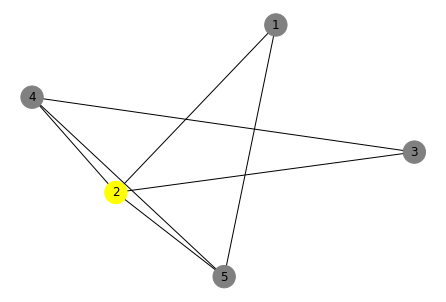

In [21]:
import networkx as nx

G = nx.Graph( )
G.add_edges_from( edges )  # Create a Graph from the given edges

color_map = []
for node in G:
    for i in range(len(cnodes)):
        if node == cnodes[i]:
            color_map.append(colors[i])
        else:
            color_map.append('grey')
if len(cnodes) == 0:
    color_map = ['grey']
    
nx.draw(G, with_labels=True, node_color = color_map, node_size = 500)

<div class="alert alert-block alert-warning">
<b>Note:</b> The networkx package is designed for analyzing graphs, rather than plotting them.
    So if the graph does not look the same as you intended, just ensure that the edges are connected properly.
</div>

In [22]:
def Np(coord, K):  # New coordinate
    i, p = coord
    return (i - 1)*K + p

In [23]:
import numpy as np

def objectiveFunction(G, K, P):
    N = len(G.nodes) 
    n = K*N  # Dimension of QUBO Matrix

    Q = np.zeros((n, n))

    ### Constraint 2 ###
    for i, j in G.edges:
        if i > j:    # Enforce upper-triangular representation
            temp = i; i = j; j = temp

        for p in range(1, K+1):
            c1 = Np((i, p), K)
            c2 = Np((j, p), K)
            Q[c1-1][c2-1] = P  # Array at 0

    ### Constraint 1 ###
    for i in range(n):
        Q[i][i] = -P
        
    for p in range(K):
        
        
        if ((i)%K == 0):    # ie, an integer (ideally i-1, however i in this loop is from 0)
            Q[i][i+1] = 2*P
            Q[i][i+2] = 2*P
        else:
            Q[i][i+1] = 2*P
    #Q[n-1][n-1] = -P        # Not covered in the loop

    return Q
# Offset of N*P is added in bqm below

In [39]:
from itertools import permutations

for p in range(K):
    print(p)

1 2
1 3
1 4
2 3
2 4
3 4


In [27]:
from dimod import BinaryQuadraticModel

P = 4
K = 3    # Number of colors
N = len(G.nodes)
Q = objectiveFunction(G, K, P)
bqm_qubo = BinaryQuadraticModel.from_numpy_matrix(Q, offset = P*N)
Q

_Alternate representation via dictionaries is commented here for a specific problem, which could be automated for graphs of size N_.
<!--
from dimod import BinaryQuadraticModel

P = 10    # Arbitrary
linear    = {'x1': -P, 'x2': -P, 'x3': -P, 'x4': -P, 'x5': -P, 'x6': -P, 'x7': -P, 'x8': -P}
quadratic = {('x1', 'x2'): 2*P, ('x3', 'x4'): 2*P, ('x5', 'x6'): 2*P, ('x7', 'x8'): 2*P, 
             ('x1', 'x7'): 2*P, ('x2', 'x8'): 2*P, ('x3', 'x5'): 2*P, ('x4', 'x6'): 2*P, 
             ('x5', 'x7'): 2*P, ('x6', 'x8'): 2*P}
offset    = 4*P
vartype   = 'BINARY'

bqm_qubo  = BinaryQuadraticModel(linear, quadratic, offset, vartype)
-->

In [28]:
from dimod.reference.samplers import ExactSolver

sampler = ExactSolver()
sampleset = sampler.sample(bqm_qubo)

print(sampleset);

       0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 energy num_oc.
15553  1  0  0  0  0  1  0  1  0  1  0  0  0  1  0    0.0       1
31219  0  1  0  1  0  0  0  0  1  0  1  0  0  0  1    0.0       1
828    0  1  0  0  0  1  0  1  0  1  0  0  0  0  0    4.0       1
830    1  0  0  0  0  1  0  1  0  1  0  0  0  0  0    4.0       1
1548   0  1  0  1  0  0  0  0  1  0  1  0  0  0  0    4.0       1
3852   0  1  0  1  0  0  0  1  0  0  0  1  0  0  0    4.0       1
3992   0  0  1  0  1  0  1  0  0  0  0  1  0  0  0    4.0       1
3998   1  0  0  0  1  0  1  0  0  0  0  1  0  0  0    4.0       1
6204   0  1  0  0  0  1  0  0  0  0  1  0  1  0  0    4.0       1
6247   0  0  1  0  1  0  1  0  0  0  1  0  1  0  0    4.0       1
6264   0  0  1  0  0  0  1  0  0  0  1  0  1  0  0    4.0       1
6268   0  1  0  0  0  0  1  0  0  0  1  0  1  0  0    4.0       1
6339   0  1  0  0  0  1  0  1  0  0  1  0  1  0  0    4.0       1
6595   0  1  0  0  0  1  0  0  1  0  1  0  1  0  0    4.0       1
6631   0  

In [29]:
print(sampleset.lowest())
print("\nThe lowest energy is ", sampleset.first.energy)

   0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 energy num_oc.
0  1  0  0  0  0  1  0  1  0  1  0  0  0  1  0    0.0       1
1  0  1  0  1  0  0  0  0  1  0  1  0  0  0  1    0.0       1
['BINARY', 2 rows, 2 samples, 15 variables]

The lowest energy is  0.0


After surveying through $2^8 = 256$ samples, we have found a double-degenerate state to be the solution. 
The result in the original notation of variables is $x_{12}=x_{33}=x_{42}=x_{53}=1$. 

This means that Node 1 & Node 4 are assigned color $p=2$ (Green) and Node 3 & Node 5 are assigned color $p=3$ (Blue). 

<img src="../images/GC3.png" width="250">

---
#### Task 1: Bipartite Graphs

Bipartite graph (or bigraph) is a graph whose vertices can be divided into two disjoint and independent sets U and V such that every edge connects a vertex in U to one in V. Vertex sets U and V are usually called the parts of the graph.

A graph is bipartite if it is 2-colourable, i.e., the chromatic number K = 2.

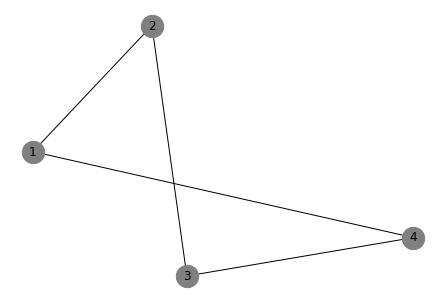

In [34]:
import networkx as nx

edges = [(1, 2), (2, 3), (3, 4), (4, 1)]
G = nx.Graph( )
G.add_edges_from( edges )  # Create a Graph from the given edges

color_map = ['grey']    
nx.draw(G, with_labels=True, node_color = color_map, node_size = 500)

<a href="BQM_GraphColoring_Solutions.ipynb#Task1">Click for the solution >></a>

---
## References
1. Quantum Bridge Analytics I: A Tutorial on Formulating and Using QUBO Models *(Fred Glover, Gary Kochenberger, Yu Du)*  &nbsp;&nbsp; [[arXiv Preprint]](https://arxiv.org/abs/1811.11538)
2. Bipartite Graphs &nbsp;&nbsp; [[GeekforGeeks]](https://www.geeksforgeeks.org/bipartite-graph/)